# Neural ODEs - An Introduction (Live Blog post)
> "This Blog post is dedicated to NeuralODEs a whole new class of Deep learning models which uses implicit layers and the parameters are modelled with dynamics of a differential equation"

- toc: true
- badges: true
- comments: true
- categories: [Deep Learning, NeuralNetworks, JAX_library , NeuralODEs, ResNets]
- image: images/neuralodes.png

## Introduction to the concept of NeuralODEs and Implicit layers
In any standard Neural network, take for an example an MLP(multi layer perceptron) we have discrete set of layers that transform the input vector(called as tensor) and apply non-linear function to the transformed vector and use classifier at the end of the network like softmax etc to make the prediction in any classification problem. The concept of implicit layers will be thinking of neural network not as explicitly defined set of layers but the depth of the model will be decided by the dynamics we introduce to the model(the ODE or any differential equation we use). So, our objective is to solve this differential equation to model the neural network(which is basically a function).

In [1]:
import jax.numpy as jnp

def mlp(params, inputs):
  # A multi-layer perceptron, i.e. a fully-connected neural network.
  for w, b in params:
    outputs = jnp.dot(inputs, w) + b  # Linear transform
    inputs = jnp.tanh(outputs)        # Nonlinearity
  return outputs

In [2]:
def resnet(params, inputs, depth):
  for i in range(depth):
    outputs = mlp(params, inputs) + inputs
  return outputs

In [3]:

import numpy.random as npr
from jax import jit, grad

resnet_depth = 3
def resnet_squared_loss(params, inputs, targets):
  preds = resnet(params, inputs, resnet_depth)
  return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

def init_random_params(scale, layer_sizes, rng=npr.RandomState(0)):
  return [(scale * rng.randn(m, n), scale * rng.randn(n))
          for m, n, in zip(layer_sizes[:-1], layer_sizes[1:])]

# A simple gradient-descent optimizer.
@jit
def resnet_update(params, inputs, targets):
  grads = grad(resnet_squared_loss)(params, inputs, targets)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]


Text(0, 0.5, 'output')

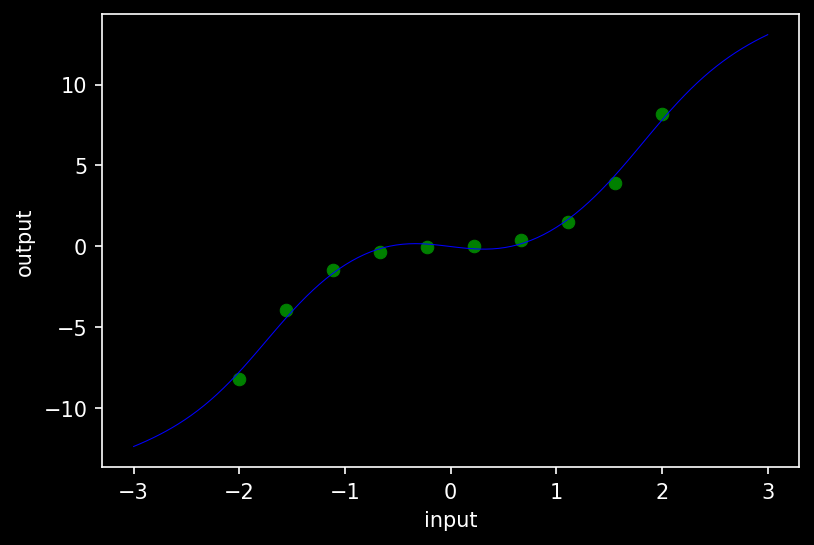

In [4]:
# Toy 1D dataset.
inputs = jnp.reshape(jnp.linspace(-2.0, 2.0, 10), (10, 1))
targets = inputs**3 + 0.1 * inputs

# Hyperparameters.
layer_sizes = [1, 20, 1]
param_scale = 1.0
step_size = 0.01
train_iters = 1000

# Initialize and train.
resnet_params = init_random_params(param_scale, layer_sizes)
for i in range(train_iters):
  resnet_params = resnet_update(resnet_params, inputs, targets)

# Plot results.
import matplotlib.pyplot as plt
plt.style.use('dark_background')
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth), lw=0.5, color='blue')
ax.set_xlabel('input')
ax.set_ylabel('output')


In [5]:
def nn_dynamics(state, time, params):
  state_and_time = jnp.hstack([state, jnp.array(time)])
  return mlp(params, state_and_time)

In [6]:
from jax.experimental.ode import odeint

def odenet(params, input):
  start_and_end_times = jnp.array([0.0, 1.0])
  init_state, final_state = odeint(nn_dynamics, input, start_and_end_times, params)
  return final_state

In [7]:
from jax import vmap
batched_odenet = vmap(odenet, in_axes=(None, 0))

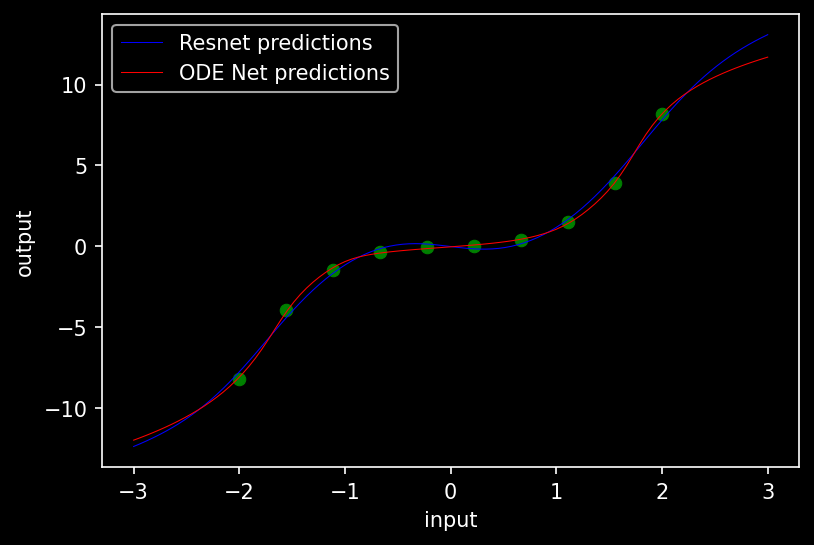

In [8]:
# We need to change the input dimension to 2, to allow time-dependent dynamics.
odenet_layer_sizes = [2, 20, 1]

def odenet_loss(params, inputs, targets):
  preds = batched_odenet(params, inputs)
  return jnp.mean(jnp.sum((preds - targets)**2, axis=1))

@jit
def odenet_update(params, inputs, targets):
  grads = grad(odenet_loss)(params, inputs, targets)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

# Initialize and train ODE-Net.
odenet_params = init_random_params(param_scale, odenet_layer_sizes)

for i in range(train_iters):
  odenet_params = odenet_update(odenet_params, inputs, targets)

# Plot resulting model.
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()
ax.scatter(inputs, targets, lw=0.5, color='green')
fine_inputs = jnp.reshape(jnp.linspace(-3.0, 3.0, 100), (100, 1))
ax.plot(fine_inputs, resnet(resnet_params, fine_inputs, resnet_depth), lw=0.5, color='blue')
ax.plot(fine_inputs, batched_odenet(odenet_params, fine_inputs), lw=0.5, color='red')
ax.set_xlabel('input')
ax.set_ylabel('output')
plt.legend(('Resnet predictions', 'ODE Net predictions'))

Text(0, 0.5, 'time / depth')

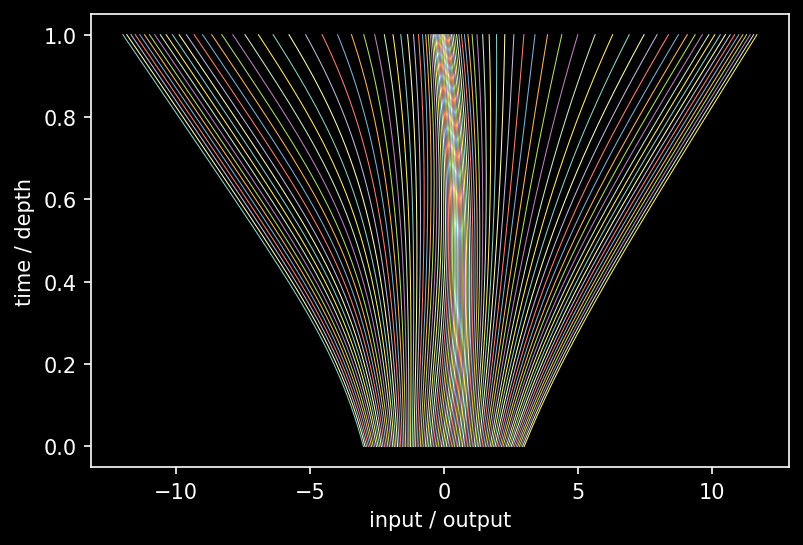

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6, 4), dpi=150)
ax = fig.gca()

@jit
def odenet_times(params, input, times):
  def dynamics_func(state, time, params):
    return mlp(params, jnp.hstack([state, jnp.array(time)]))
  return odeint(dynamics_func, input, times, params)

times = jnp.linspace(0.0, 1.0, 200)

for i in fine_inputs:
  ax.plot(odenet_times(odenet_params, i, times), times, lw=0.5)

ax.set_xlabel('input / output')
ax.set_ylabel('time / depth')